# work-flow
1. 데이터 현황 파악 (Data Audit):
 - 수집된 damaged, normal, background 폴더의 실제 이미지 개수를 카운트하여 테스트 데이터셋(Testset)의 규모를 확정
2. 알고리즘 선정 (Model Selection):
 - 원본 해상도 이미지에서 '객체'를 찾아내는 능력이 탁월한 Object Detection 모델을 선정
3. 추론 수행 (Inference):
 - 이미지를 모델에 입력 -> 탐지된 객체 리스트 확인.
 - Logic: Car(2), Bus(5), Truck(7) 중 하나라도 있으면 Class 1 (Vehicle), 없으면 Class 0 (Non-Vehicle) 로 판정.
4. 결과 평가 (Evaluation):
 - 실제 정답(폴더명) vs 모델 예측값을 비교.
 - 정확도(Accuracy), 정밀도(Precision), 재현율(Recall) 산출.
 - 실패 사례(Failure Case) 분석: 모델이 왜 틀렸는지 확인하여 향후 Fine-tuning 필요성 판단.

# 1. 데이터 현황 파악 (Data Audit)

In [ ]:
# [Cell 1] 라이브러리 설치 및 드라이브 마운트
from google.colab import drive
import os

# 1. 구글 드라이브 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# 데이터 경로 (No Resizing 버전)
DATA_ROOT = "/content/drive/MyDrive/03. HDMF/(share)2026_ImageDetectionStudy_No_resizing"

def check_dataset_status():
    print("📊 [데이터셋 현황 점검]")
    print(f"대상 경로: {DATA_ROOT}\n")

    total_count = 0
    vehicle_count = 0
    non_vehicle_count = 0

    # 폴더별 정의 (폴더명, 차량여부)
    folders = {
        "damaged": True,    # 차량 O
        "normal": True,     # 차량 O
        "background": False # 차량 X
    }

    for folder, is_vehicle in folders.items():
        img_dir = os.path.join(DATA_ROOT, folder, "images")

        if os.path.exists(img_dir):
            # 이미지 파일만 카운트
            files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            count = len(files)

            label_str = "차량(Vehicle)" if is_vehicle else "비차량(Non-Vehicle)"
            print(f" - [{folder:<10}] : {count}장 ({label_str})")

            total_count += count
            if is_vehicle:
                vehicle_count += count
            else:
                non_vehicle_count += count
        else:
            print(f"⚠️ 경고: {folder} 폴더를 찾을 수 없습니다.")

    print("-" * 30)
    print(f"🏆 총 이미지 수 : {total_count}장")
    print(f"   🚗 차량 이미지: {vehicle_count}장")
    print(f"   🚗 차량 이미지 비율: {vehicle_count/total_count*100}%")
    print(f"   🚫 비차량 이미지: {non_vehicle_count}장")

check_dataset_status()

📊 [데이터셋 현황 점검]
대상 경로: /content/drive/MyDrive/03. HDMF/(share)2026_ImageDetectionStudy_No_resizing

 - [damaged   ] : 1200장 (차량(Vehicle))
 - [normal    ] : 157장 (차량(Vehicle))
 - [background] : 600장 (비차량(Non-Vehicle))
------------------------------
🏆 총 이미지 수 : 1957장
   🚗 차량 이미지: 1357장
   🚗 차량 이미지 비율: 69.34082779764947%
   🚫 비차량 이미지: 600장


## 2. 알고리즘 선정 (Model Selection)
 - YOLOv8x (Extra Large)
 - 원본 해상도 활용: CNN 분류 모델(ResNet 등)은 이미지를 224x224로 찌그러뜨려야 하지만, YOLO는 원본 비율을 유지하며 고해상도 처리가 가능
 - 작은 객체 탐지: 배경 속에 작게 찍힌 차량이나, 일부만 나온 차량도 잘 찾음
 - 검증된 성능: COCO 데이터셋으로 이미 학습되어 있어, 추가 학습 없이도 차량 인식이 가능

In [ ]:
# [Cell 1] 라이브러리 설치
!pip install ultralytics scikit-learn pandas matplotlib seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.3 MB/s eta 0:00:00


### 샘플 테스트

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
📂 이미지 목록을 수집 중입니다...
🎯 선택된 이미지: background / bg_0011.jpg

image 1/1 /content/drive/MyDrive/03. HDMF/(share)2026_ImageDetectionStudy_No_resizing/background/images/bg_0011.jpg: 448x640 1 dog, 7 sheeps, 130.3ms
Speed: 4.9ms preprocess, 130.3ms inference, 12.3ms postprocess per image at shape (1, 3, 448, 640)


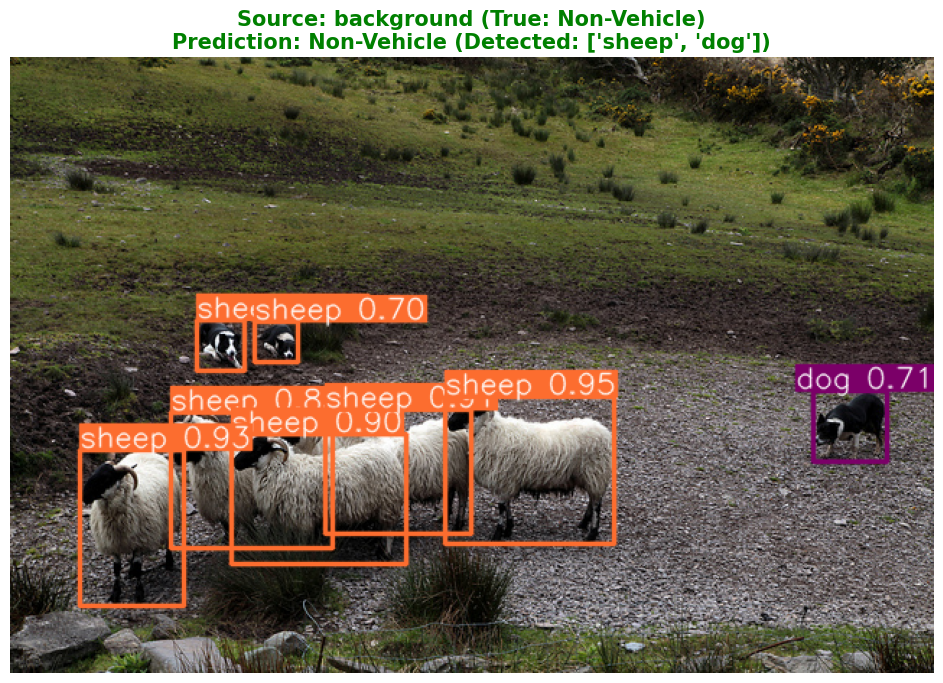

In [ ]:
# [Cell 2] 랜덤 샘플 시각화
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# =========================================================
# [설정]
# =========================================================
DATA_ROOT = "/content/drive/MyDrive/03. HDMF/(share)2026_ImageDetectionStudy_No_resizing"
MODEL_NAME = 'yolov8x.pt'  # 모델
TARGET_CLASSES = [2, 5, 7] # Car, Bus, Truck

# =========================================================
# [실행 로직]
# =========================================================
def visualize_random_inference():
    # 1. 전체 이미지 리스트 확보
    all_images = []
    target_folders = ['damaged', 'normal', 'background']

    print("📂 이미지 목록을 수집 중입니다...")
    for folder in target_folders:
        folder_path = os.path.join(DATA_ROOT, folder, "images")
        if os.path.exists(folder_path):
            files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            for f in files:
                all_images.append({
                    "path": os.path.join(folder_path, f),
                    "folder": folder, # 정답(Ground Truth) 확인용
                    "filename": f
                })

    if not all_images:
        print("❌ 이미지를 찾을 수 없습니다. 경로를 확인해주세요.")
        return

    # 2. 랜덤 선택
    selected = random.choice(all_images)
    print(f"🎯 선택된 이미지: {selected['folder']} / {selected['filename']}")

    # 3. 모델 로드 및 추론
    model = YOLO(MODEL_NAME)
    results = model(selected['path']) # conf는 기본값 사용

    # 4. 결과 분석 (차량 여부 판단)
    is_vehicle = False
    detected_classes = []

    for r in results:
        for box in r.boxes:
            cls_id = int(box.cls[0])
            cls_name = model.names[cls_id]
            detected_classes.append(cls_name)

            if cls_id in TARGET_CLASSES:
                is_vehicle = True

    # 5. 시각화
    # results[0].plot()은 BBox가 그려진 이미지를 numpy array(BGR)로 반환합니다.
    annotated_frame = results[0].plot()

    # Colab/Matplotlib은 RGB를 쓰므로 BGR -> RGB 변환
    annotated_frame_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)

    # 결과 출력
    plt.figure(figsize=(12, 8))
    plt.imshow(annotated_frame_rgb)

    # 제목 설정 (정답 vs 예측)
    true_label = "Vehicle" if selected['folder'] in ['damaged', 'normal'] else "Non-Vehicle"
    pred_label = "Vehicle" if is_vehicle else "Non-Vehicle"
    color = "green" if true_label == pred_label else "red"

    title_text = f"Source: {selected['folder']} (True: {true_label})\n"
    title_text += f"Prediction: {pred_label} (Detected: {list(set(detected_classes))})"

    plt.title(title_text, color=color, fontsize=15, fontweight='bold')
    plt.axis('off')
    plt.show()

# 실행
visualize_random_inference()

### 전체 수행. confidence threshold : 0.25

🚀 모델 로드 중 (yolov8x.pt)...

🚀 Inference 시작 (속도 측정 포함)...


Processing background: 100%|██████████| 600/600 [00:36<00:00, 16.45it/s]



📊 [최종 분석 결과]
✅ 1. 정확도 (Accuracy): 0.8549 (85.49%)

⚡ 2. 추론 속도 (Inference Speed):
   - 평균 소요 시간 : 47.94 ms/장
   - 최소 소요 시간 : 23.45 ms
   - 최대 소요 시간 : 79.84 ms
   - 처리량 (FPS)   : 20.86 FPS

📝 3. 상세 분류 리포트:
              precision    recall  f1-score   support

 Non-Vehicle       0.68      0.99      0.81       600
     Vehicle       0.99      0.80      0.88      1357

    accuracy                           0.85      1957
   macro avg       0.84      0.89      0.85      1957
weighted avg       0.90      0.85      0.86      1957



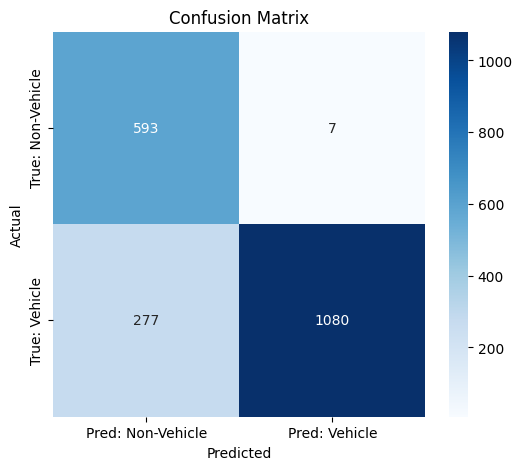


💾 전체 실행 결과 저장 완료!
   -> 파일 경로: /content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification/inference_full_results_conf025.csv
   -> 총 데이터 수: 1957건
   -> (성공: 1673건, 실패: 284건)


In [ ]:
# [Cell 2] Inference 수행, 성능 평가 및 속도 체크 (전체 결과 저장 버전)
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import numpy as np

# =========================================================
# [설정]
# =========================================================
# 1. 데이터를 읽어올 경로 (Source)
DATA_ROOT = "/content/drive/MyDrive/03. HDMF/(share)2026_ImageDetectionStudy_No_resizing"

# 2. 결과를 저장할 경로 (Target)
RESULT_ROOT = "/content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification"

MODEL_NAME = 'yolov8x.pt'  # 가장 무겁지만 성능 좋은 모델
CONF_THRESHOLD = 0.25      # 확신도 25% 이상만 인정
TARGET_CLASSES = [2, 5, 7] # COCO Class ID: Car(2), Bus(5), Truck(7)

# =========================================================
# [실행 로직]
# =========================================================
def run_vehicle_classification_with_speed():
    # 0. 결과 저장 폴더 생성
    os.makedirs(RESULT_ROOT, exist_ok=True)

    # 1. 모델 로드
    print(f"🚀 모델 로드 중 ({MODEL_NAME})...")
    model = YOLO(MODEL_NAME)

    results_list = [] # 결과 저장용
    speed_stats = []  # 속도 측정용 (ms)

    # 2. 데이터 순회 및 추론
    target_folders = {
        "damaged": 1,    # 차량
        "normal": 1,     # 차량
        "background": 0  # 비차량
    }

    print("\n🚀 Inference 시작 (속도 측정 포함)...")

    for folder, true_label in target_folders.items():
        folder_path = os.path.join(DATA_ROOT, folder, "images")
        if not os.path.exists(folder_path): continue

        files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

        for file in tqdm(files, desc=f"Processing {folder}"):
            img_path = os.path.join(folder_path, file)

            # [YOLO 추론]
            results = model(img_path, conf=CONF_THRESHOLD, verbose=False)

            # [속도 측정]
            speed_info = results[0].speed
            total_time_ms = speed_info['preprocess'] + speed_info['inference'] + speed_info['postprocess']
            speed_stats.append(total_time_ms)

            # [판단 로직]
            pred_label = 0
            for result in results:
                for box in result.boxes:
                    if int(box.cls[0]) in TARGET_CLASSES:
                        pred_label = 1 # 차량 발견
                        break
                if pred_label == 1: break

            # 결과 리스트에 추가 (성공/실패 여부 포함)
            is_correct = (true_label == pred_label)
            results_list.append({
                "filename": file,
                "folder": folder,
                "true_label": true_label,
                "pred_label": pred_label,
                "is_correct": is_correct, # 맞았는지 틀렸는지
                "full_path": img_path
            })

    # 3. 데이터프레임 변환
    df = pd.DataFrame(results_list)

    # =========================================================
    # [분석 결과 리포트]
    # =========================================================
    print("\n" + "="*50)
    print("📊 [최종 분석 결과]")
    print("="*50)

    # A. 정확도 평가
    acc = accuracy_score(df['true_label'], df['pred_label'])
    print(f"✅ 1. 정확도 (Accuracy): {acc:.4f} ({acc*100:.2f}%)")

    # B. 속도 평가
    if speed_stats:
        avg_time = np.mean(speed_stats)
        min_time = np.min(speed_stats)
        max_time = np.max(speed_stats)
        fps = 1000 / avg_time

        print(f"\n⚡ 2. 추론 속도 (Inference Speed):")
        print(f"   - 평균 소요 시간 : {avg_time:.2f} ms/장")
        print(f"   - 최소 소요 시간 : {min_time:.2f} ms")
        print(f"   - 최대 소요 시간 : {max_time:.2f} ms")
        print(f"   - 처리량 (FPS)   : {fps:.2f} FPS")

    # C. 상세 분류 리포트
    print("\n📝 3. 상세 분류 리포트:")
    print(classification_report(df['true_label'], df['pred_label'], target_names=['Non-Vehicle', 'Vehicle']))

    # D. 혼동 행렬 시각화
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(df['true_label'], df['pred_label'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred: Non-Vehicle', 'Pred: Vehicle'],
                yticklabels=['True: Non-Vehicle', 'True: Vehicle'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # =========================================================
    # E. [수정됨] 전체 데이터 실행 결과 저장
    # =========================================================
    save_path = os.path.join(RESULT_ROOT, "inference_full_results_conf025.csv")

    # 한글 깨짐 방지를 위해 utf-8-sig 사용
    df.to_csv(save_path, index=False, encoding='utf-8-sig')

    print(f"\n💾 전체 실행 결과 저장 완료!")
    print(f"   -> 파일 경로: {save_path}")
    print(f"   -> 총 데이터 수: {len(df)}건")

    # 실패 건수 요약 출력 (참고용)
    failed_count = len(df[df['is_correct'] == False])
    print(f"   -> (성공: {len(df)-failed_count}건, 실패: {failed_count}건)")

run_vehicle_classification_with_speed()

### 에러 사유 확인 (FN 277개)

In [ ]:
# [Cell 2] 메인 실행 코드
import sys
import os

# 1. 프로젝트 경로 설정 (utils.py 및 csv 파일이 있는 곳)
PROJECT_PATH = "/content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification"
# 2. 시스템 경로에 추가 (utils를 import하기 위해)
if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)
import utils  # 방금 만든 모듈 import
# 1. 영역 선택 (TP, TN, FP, FN)
TARGET_CATEGORY = "FN"

# 2. 번호 선택 (0번부터 시작)
TARGET_INDEX = 11
# =========================================================
# 3. 전체 결과 파일 경로
FULL_CSV_PATH = os.path.join(PROJECT_PATH, "inference_full_results_conf025.csv")

# 4. 시각화 실행
# model_path는 사용하셨던 모델명('yolov8x.pt')을 입력
utils.visualize_confusion_matrix_sample(
    csv_path=FULL_CSV_PATH,
    category=TARGET_CATEGORY,
    index=TARGET_INDEX,
    model_path='yolov8x.pt'
)

 - [FP] 차가 배경에 아주 작게 있는 경우
 - [FN]전체 화면에 차량의 일부분이 너무 크게 차지하여, 전체 차량의 형태를 파악하기 어려운 경우
 -

## 모델 튜닝

### 파라미터 튜닝1. CONF_THRESHOLD : 0.1
 - FN가 높은 상태로, confidence threshold를 낮춰서 개선, 다만 FP가 높아질 수 있음

🚀 모델 로드 중 (yolov8x.pt)...

🚀 Inference 시작 (속도 측정 포함)...


Processing background: 100%|██████████| 600/600 [00:37<00:00, 16.09it/s]



📊 [최종 분석 결과]
✅ 1. 정확도 (Accuracy): 0.8871 (88.71%)

⚡ 2. 추론 속도 (Inference Speed):
   - 평균 소요 시간 : 48.23 ms/장
   - 최소 소요 시간 : 22.05 ms
   - 최대 소요 시간 : 83.91 ms
   - 처리량 (FPS)   : 20.73 FPS

📝 3. 상세 분류 리포트:
              precision    recall  f1-score   support

 Non-Vehicle       0.74      0.96      0.84       600
     Vehicle       0.98      0.85      0.91      1357

    accuracy                           0.89      1957
   macro avg       0.86      0.91      0.88      1957
weighted avg       0.91      0.89      0.89      1957



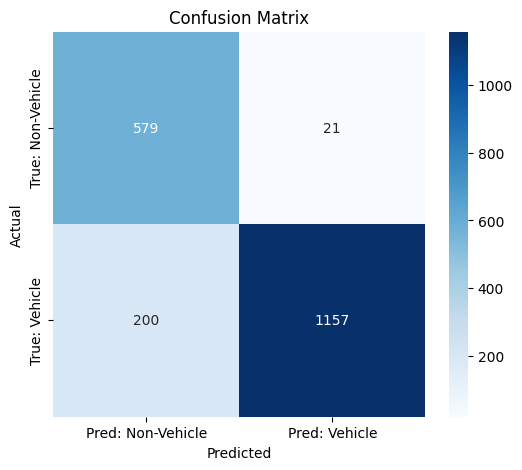


💾 전체 실행 결과 저장 완료!
   -> 파일 경로: /content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification/inference_full_results_conf01.csv
   -> 총 데이터 수: 1957건
   -> (성공: 1736건, 실패: 221건)


In [ ]:
# [Cell 2] Inference 수행, 성능 평가 및 속도 체크 (전체 결과 저장 버전)
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import numpy as np

# =========================================================
# [설정]
# =========================================================
# 1. 데이터를 읽어올 경로 (Source)
DATA_ROOT = "/content/drive/MyDrive/03. HDMF/(share)2026_ImageDetectionStudy_No_resizing"

# 2. 결과를 저장할 경로 (Target)
RESULT_ROOT = "/content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification"

MODEL_NAME = 'yolov8x.pt'  # 가장 무겁지만 성능 좋은 모델
CONF_THRESHOLD = 0.1     # 확신도 25% 이상만 인정
TARGET_CLASSES = [2, 5, 7] # COCO Class ID: Car(2), Bus(5), Truck(7)

# =========================================================
# [실행 로직]
# =========================================================
def run_vehicle_classification_with_speed():
    # 0. 결과 저장 폴더 생성
    os.makedirs(RESULT_ROOT, exist_ok=True)

    # 1. 모델 로드
    print(f"🚀 모델 로드 중 ({MODEL_NAME})...")
    model = YOLO(MODEL_NAME)

    results_list = [] # 결과 저장용
    speed_stats = []  # 속도 측정용 (ms)

    # 2. 데이터 순회 및 추론
    target_folders = {
        "damaged": 1,    # 차량
        "normal": 1,     # 차량
        "background": 0  # 비차량
    }

    print("\n🚀 Inference 시작 (속도 측정 포함)...")

    for folder, true_label in target_folders.items():
        folder_path = os.path.join(DATA_ROOT, folder, "images")
        if not os.path.exists(folder_path): continue

        files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

        for file in tqdm(files, desc=f"Processing {folder}"):
            img_path = os.path.join(folder_path, file)

            # [YOLO 추론]
            results = model(img_path, conf=CONF_THRESHOLD, verbose=False)

            # [속도 측정]
            speed_info = results[0].speed
            total_time_ms = speed_info['preprocess'] + speed_info['inference'] + speed_info['postprocess']
            speed_stats.append(total_time_ms)

            # [판단 로직]
            pred_label = 0
            for result in results:
                for box in result.boxes:
                    if int(box.cls[0]) in TARGET_CLASSES:
                        pred_label = 1 # 차량 발견
                        break
                if pred_label == 1: break

            # 결과 리스트에 추가 (성공/실패 여부 포함)
            is_correct = (true_label == pred_label)
            results_list.append({
                "filename": file,
                "folder": folder,
                "true_label": true_label,
                "pred_label": pred_label,
                "is_correct": is_correct, # 맞았는지 틀렸는지
                "full_path": img_path
            })

    # 3. 데이터프레임 변환
    df = pd.DataFrame(results_list)

    # =========================================================
    # [분석 결과 리포트]
    # =========================================================
    print("\n" + "="*50)
    print("📊 [최종 분석 결과]")
    print("="*50)

    # A. 정확도 평가
    acc = accuracy_score(df['true_label'], df['pred_label'])
    print(f"✅ 1. 정확도 (Accuracy): {acc:.4f} ({acc*100:.2f}%)")

    # B. 속도 평가
    if speed_stats:
        avg_time = np.mean(speed_stats)
        min_time = np.min(speed_stats)
        max_time = np.max(speed_stats)
        fps = 1000 / avg_time

        print(f"\n⚡ 2. 추론 속도 (Inference Speed):")
        print(f"   - 평균 소요 시간 : {avg_time:.2f} ms/장")
        print(f"   - 최소 소요 시간 : {min_time:.2f} ms")
        print(f"   - 최대 소요 시간 : {max_time:.2f} ms")
        print(f"   - 처리량 (FPS)   : {fps:.2f} FPS")

    # C. 상세 분류 리포트
    print("\n📝 3. 상세 분류 리포트:")
    print(classification_report(df['true_label'], df['pred_label'], target_names=['Non-Vehicle', 'Vehicle']))

    # D. 혼동 행렬 시각화
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(df['true_label'], df['pred_label'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred: Non-Vehicle', 'Pred: Vehicle'],
                yticklabels=['True: Non-Vehicle', 'True: Vehicle'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # =========================================================
    # E. [수정됨] 전체 데이터 실행 결과 저장
    # =========================================================
    save_path = os.path.join(RESULT_ROOT, "inference_full_results_conf01.csv")

    # 한글 깨짐 방지를 위해 utf-8-sig 사용
    df.to_csv(save_path, index=False, encoding='utf-8-sig')

    print(f"\n💾 전체 실행 결과 저장 완료!")
    print(f"   -> 파일 경로: {save_path}")
    print(f"   -> 총 데이터 수: {len(df)}건")

    # 실패 건수 요약 출력 (참고용)
    failed_count = len(df[df['is_correct'] == False])
    print(f"   -> (성공: {len(df)-failed_count}건, 실패: {failed_count}건)")

run_vehicle_classification_with_speed()

[confidence threshold 낮춘 결과. 0.25->0.1]
 1. 속도의 차이 거의 없음
 2. vehicle recall 상승 (0.8 - > 0.85)
 3. 비차량 Recall 하락 (0.99 → 0.96):

🔍 [분석 정보] Category: FN | Index: 2 / 199
   - 파일명: 0211742_as-2534423.jpg
   - 출처폴더: damaged
   - 설명: False Negative (정답: 차 O -> 예측: 차 X)
   - 경로: /content/drive/MyDrive/03. HDMF/(share)2026_ImageDetectionStudy_No_resizing/damaged/images/0211742_as-2534423.jpg


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45813 (\N{HANGUL SYLLABLE DAB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


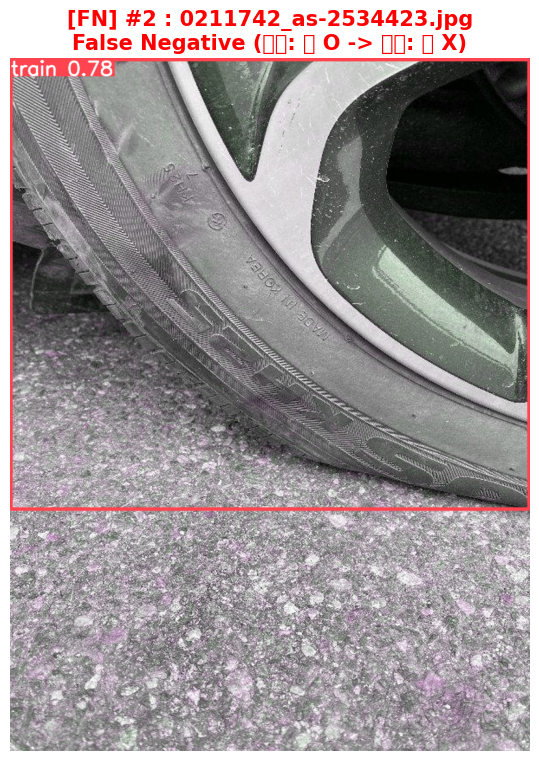

In [ ]:
# [Cell 2] 메인 실행 코드
import sys
import os

# 1. 프로젝트 경로 설정 (utils.py 및 csv 파일이 있는 곳)
PROJECT_PATH = "/content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification"
# 2. 시스템 경로에 추가 (utils를 import하기 위해)
if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)
import utils  # 방금 만든 모듈 import
# 1. 영역 선택 (TP, TN, FP, FN)
TARGET_CATEGORY = "FN"

# 2. 번호 선택 (0번부터 시작)
TARGET_INDEX = 2
# =========================================================
# 3. 전체 결과 파일 경로
FULL_CSV_PATH = os.path.join(PROJECT_PATH, "inference_full_results_conf01.csv")

# 4. 시각화 실행
# model_path는 사용하셨던 모델명('yolov8x.pt')을 입력
utils.visualize_confusion_matrix_sample(
    csv_path=FULL_CSV_PATH,
    category=TARGET_CATEGORY,
    index=TARGET_INDEX,
    model_path='yolov8x.pt'
)